In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
from itertools import combinations
import wikipedia
from fuzzywuzzy import fuzz
import pgeocode
from math import sin, cos, sqrt, atan2, radians
from scipy import stats as sps

In [2]:
# the csv file should be ready to read; run this cell first, if not working...
# get this data from Bowen's https://colab.research.google.com/drive/1-IJfwIFxVmaIWNSfL3QdgAFJ7Pm8j-7w#scrollTo=Yx9MwLc0er4J 
# and re-upload by running first 2 lines of last cell

data = pd.read_csv('cleaned_data.csv', dtype = {'Cardnum':'str', 'Merchnum':'str' ,'Merch zip': 'str', 'Merch state': 'str'}, parse_dates = ['Date']).iloc[:,1:]
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


In [3]:
data.shape

(96205, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96205 entries, 0 to 96204
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96205 non-null  int64         
 1   Cardnum            96205 non-null  object        
 2   Date               96205 non-null  datetime64[ns]
 3   Merchnum           96205 non-null  object        
 4   Merch description  96205 non-null  object        
 5   Merch state        96205 non-null  object        
 6   Merch zip          96205 non-null  object        
 7   Transtype          96205 non-null  object        
 8   Amount             96205 non-null  float64       
 9   Fraud              96205 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 7.3+ MB


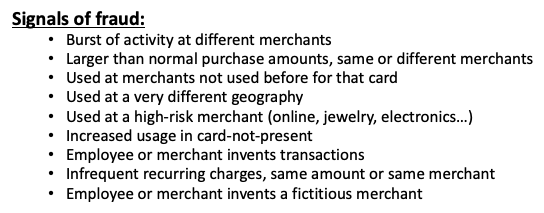

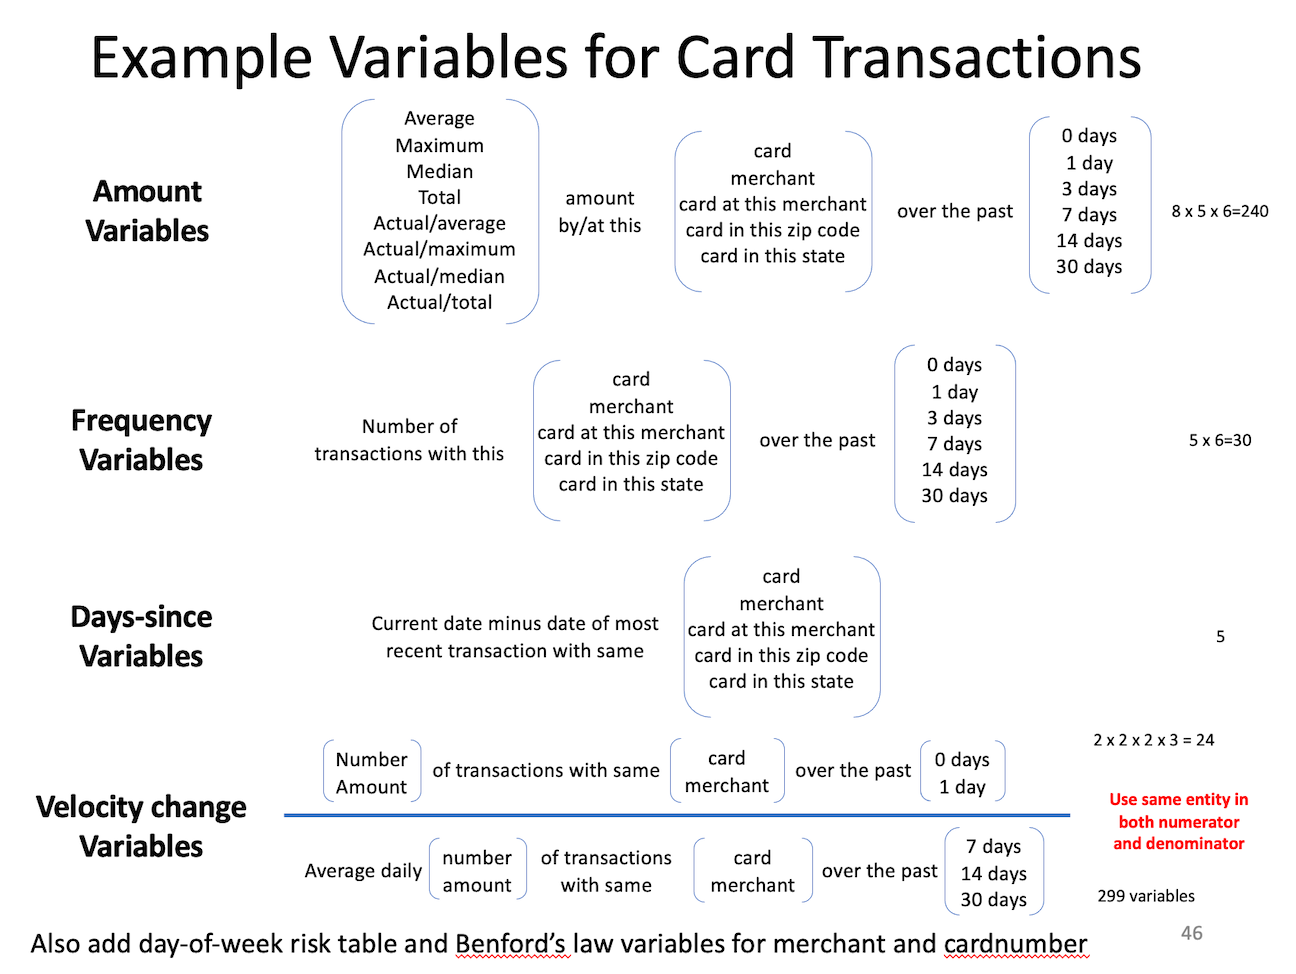

In [5]:
# Sets new name for merch description
data['Merch_description'] = data['Merch description']

# Function that cleans merch description of specific characters
def replace(replace, add):
    data['Merch_description'] = data['Merch_description'].str.replace(replace, add, case = False)
    
# Sets punctuation to be removed
punctuation = ['/><br', '-', ',', '_', "\"", "\'", "-", "\(", "\)", "\?", '!', "/", '$', '#', '[0-9]', '\*', " "]

# Cleans merch description of punctuation
for single in punctuation: 
    if single == ' ':
        data['Merch_description_space'] = data['Merch_description']
    replace(single, '')

In [6]:
industries = pd.read_csv('industry.csv')

original = pd.DataFrame(columns = ['Merch_description_space', 'Industry'])
companies = list(data['Merch_description_space'].value_counts()[data['Merch_description_space'].value_counts() > 1].index)

for count in range(len(companies)):
    if count % 1000 == 0: 
        print('Finished: ', count)
    i = companies[count]
    try:
        save = wikipedia.summary(i, sentences = 2) # Search wikipedia for two sentence descriptions
        view = {}
        
        # Only keeps words of length 5
        save = [word for word in save.split() if len(word) >= 5]
        
        # Loops through each word and gets a fuzzy ratio for each combination
        for word in save:
            for industry in list(industries['Industry'].unique()):
                word = word.lower()
                industry = industry.lower()
                view[(word, industry)] = fuzz.ratio(word, industry)
        
        # Finds the best match between industry and description
        bestmatch = max(view, key = view.get)
        original.loc[count, 'Merch_description_space'] = i
        original.loc[count, 'Industry'] = bestmatch[1]
    except:
        # Assigns any blank searches to unknown
        original.loc[count, 'Merch_description_space'] = i
        original.loc[count, 'Industry'] = 'unknown'

Finished:  0
Finished:  1000
Finished:  2000
Finished:  3000
Finished:  4000
Finished:  5000


In [7]:
# Fills all industry names into NA
original['Industry'].fillna('unknown', inplace = True)
data = pd.merge(data, original, on = 'Merch_description_space', how = 'left')

In [12]:
# create concat features first for card, merchant, zip and state 
#df_concat = data.iloc[:, [1, 3, 5, 6]]
df_concat = pd.DataFrame()

a = combinations(data.iloc[:, [1, 3, 5, 6, 10, 12]].columns, 2) 
for i in a:
    df_concat[i[0]+"_"+i[1]] = data[i[0]] + "_" + data[i[1]]

data = pd.concat([data, df_concat], axis = 1)
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merchnum_Merch state,Merchnum_Merch zip,Merchnum_Merch_description,Merchnum_Industry,Merch state_Merch zip,Merch state_Merch_description,Merch state_Industry,Merch zip_Merch_description,Merch zip_Industry,Merch_description_Industry
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,5509006296254_TN,5509006296254_38118,5509006296254_FEDEXSHPAB,5509006296254_unknown,TN_38118,TN_FEDEXSHPAB,TN_unknown,38118_FEDEXSHPAB,38118_unknown,FEDEXSHPAB_unknown
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,61003026333_MA,61003026333_01803,61003026333_SERVICEMERCHANDISE,61003026333_services,MA_01803,MA_SERVICEMERCHANDISE,MA_services,01803_SERVICEMERCHANDISE,01803_services,SERVICEMERCHANDISE_services
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,4503082993600_MD,4503082993600_20706,4503082993600_OFFICEDEPOT,4503082993600_retail,MD_20706,MD_OFFICEDEPOT,MD_retail,20706_OFFICEDEPOT,20706_retail,OFFICEDEPOT_retail
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,5509006296254_TN,5509006296254_38118,5509006296254_FEDEXSHPAB,5509006296254_unknown,TN_38118,TN_FEDEXSHPAB,TN_unknown,38118_FEDEXSHPAB,38118_unknown,FEDEXSHPAB_unknown
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,5509006296254_TN,5509006296254_38118,5509006296254_FEDEXSHPAB,5509006296254_unknown,TN_38118,TN_FEDEXSHPAB,TN_unknown,38118_FEDEXSHPAB,38118_unknown,FEDEXSHPAB_unknown


In [13]:
# Declares two new columns
data['MostCommonZip'] = np.nan 
data['MostCommonZipMinusInd'] = np.nan 

In [14]:
# Finds teh most common zip code for a card over a rolling window
for i in list(data['Recnum']):
    card = data.loc[data['Recnum'] == i, 'Cardnum'].values[0]
    stored = data.loc[(data['Cardnum'] == card) & (data['Recnum'] <= i)]
    
    # Stores the most common zip code up until that point
    data.loc[data['Recnum'] == i, 'MostCommonZip'] = stored['Merch zip'].mode().values[0]
    ind = stored.loc[stored['Industry'].isna()]
    
    # Stores only zip codes that don't have an industry value
    if len(ind) == 0: 
        data.loc[data['Recnum'] == i, 'MostCommonZipMinusInd'] = stored['Merch zip'].mode().values[0]
    else: 
        data.loc[data['Recnum'] == i, 'MostCommonZipMinusInd'] = ind['Merch zip'].mode().values[0]

In [15]:
nomi = pgeocode.Nominatim('us')

# Gets all postal codes in the US
postcodes = nomi.query_postal_code(list(data['Merch zip'].unique()))

# Saves the lat and longitude for each zip code
original = postcodes[['postal_code', 'latitude', 'longitude']]
mostcommon = postcodes[['postal_code', 'latitude', 'longitude']]
mostcommonind = postcodes[['postal_code', 'latitude', 'longitude']]
original.columns = ['Merch zip', 'LAT_original', 'LONG_original']
mostcommon.columns = ['MostCommonZip', 'LAT_most', 'LONG_most']
mostcommonind.columns = ['MostCommonZipMinusInd', 'LAT_mostind', 'LONG_mostind']

# Compines the lat long of all the zip codes with the most common ones
data = pd.merge(data, original, on = 'Merch zip', how = 'left')
data = pd.merge(data, mostcommon, on = 'MostCommonZip', how = 'left')
data = pd.merge(data, mostcommonind, on = 'MostCommonZipMinusInd', how = 'left')

In [16]:
# Function that calculates the Haversine distance between two zip codes
def get_distance(point1, point2, point3, point4):
    R = 6370
    lat1 = np.radians(point1)  #insert value
    lon1 = np.radians(point2)
    lat2 = np.radians(point3)
    lon2 = np.radians(point4)

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

In [17]:
# Finds the distances between two zip codes
data['OriginalMostDistance'] = get_distance(data['LAT_original'], data['LONG_original'], data['LAT_most'], data['LONG_most'])
data['OriginalMostIndDistance'] = get_distance(data['LAT_original'], data['LONG_original'], data['LAT_mostind'], data['LONG_mostind'])
data['IndMostDistance'] = get_distance(data['LAT_mostind'], data['LONG_mostind'], data['LAT_most'], data['LONG_most'])

# Fills any NA values to zero
data['OriginalMostDistance'].fillna(0, inplace = True)
data['OriginalMostIndDistance'].fillna(0, inplace = True)
data['IndMostDistance'].fillna(0, inplace = True)

In [19]:
df1 = data.copy()
final = data.copy() 
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum
entities = ['Cardnum', 'Merchnum', 'Merch_description', 'Cardnum_Merchnum', 'Cardnum_Merch_description',
            'Cardnum_Merch state', 'Cardnum_Merch zip', 'Cardnum_Industry'] 

In [20]:
# Sets the numeric value to calculate as these three groups
for numeric in ['Amount', 'OriginalMostDistance', 'OriginalMostIndDistance']:
    for entity in entities:
        df_1 = df1[['Recnum', 'Date', entity]]
        df_r = df1[['check_record','check_date', numeric, entity]]
        temp = pd.merge(df_1, df_r, left_on = entity, right_on=entity)

      # days since:
        day_since_df = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']] \
              .groupby('Recnum')[['Date', 'check_date']].last() 

        mapper = (day_since_df.Date - day_since_df.check_date).dt.days
        final[numeric + '_' + entity + '_day_since_'] = final.Recnum.map(mapper)
        final[numeric + '_' + entity + '_day_since_'].fillna(365, inplace = True)

      # Amount variables (mean, max, median, sum) & frequency (count)
        for offset_t in [0,1,3,7,14,30, 180, 365]: 
            count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                              & (temp.Recnum >= temp.check_record)]

            for stats in ['mean','max','median','sum','count']:
                mapper2 = count_day_df.groupby('Recnum')[numeric].agg(stats)
                col_name = f'{numeric}_{entity}_{stats}_{offset_t}'
                final[col_name] = final.Recnum.map(mapper2) 
                if stats != 'count':
                    col_name_ratio = f'{numeric}_{entity}_actual/{stats}_{offset_t}'
                    final[col_name_ratio] = final[numeric] / final[col_name]

        print(f'Finished {entity} {numeric} -------------- Done')

Finished Cardnum Amount -------------- Done
Finished Merchnum Amount -------------- Done
Finished Merch_description Amount -------------- Done
Finished Cardnum_Merchnum Amount -------------- Done
Finished Cardnum_Merch_description Amount -------------- Done
Finished Cardnum_Merch state Amount -------------- Done
Finished Cardnum_Merch zip Amount -------------- Done
Finished Cardnum_Industry Amount -------------- Done
Finished Cardnum OriginalMostDistance -------------- Done
Finished Merchnum OriginalMostDistance -------------- Done
Finished Merch_description OriginalMostDistance -------------- Done
Finished Cardnum_Merchnum OriginalMostDistance -------------- Done
Finished Cardnum_Merch_description OriginalMostDistance -------------- Done
Finished Cardnum_Merch state OriginalMostDistance -------------- Done
Finished Cardnum_Merch zip OriginalMostDistance -------------- Done
Finished Cardnum_Industry OriginalMostDistance -------------- Done
Finished Cardnum OriginalMostIndDistance -----

In [21]:
start = time.time()
# Finds teh velocity change for these three numeric value calculations
for numeric in ['Amount', 'OriginalMostDistance', 'OriginalMostIndDistance']:
    for att in entities:
        for d in ['0', '1', '3']:
            for dd in ['3', '7', '14', '30', '180', '365']:
                final[numeric + '_' + att + '_count_' + d + '_by_' + dd] \
                    = final[numeric + '_' + att + '_count_' + d] / (final[numeric + '_' + att + '_count_' + dd] / float(dd))
print(f'Total run time: {time.time() - start:0.2f}s')

Total run time: 12.80s


In [22]:
c= 4
nmid = 20

# DOW risk table 

final['dow'] = final['Date'].dt.day_name()

y_avg = final['Fraud'].mean()

y_dow = final.groupby('dow')['Fraud'].mean()
num = final.groupby('dow').size() 

y_dow_smooth = y_avg + (y_dow - y_avg) / (1 + np.exp(-(num - nmid)/c))

#y_dow_smooth

final['dow_risk'] = final.dow.map(y_dow_smooth)

In [23]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Subsets data for KS/FDR filter method
final_subset = final[final['Date'] < '11-01-10']
final_subset = final_subset[final_subset['Date'] > '01-14-10']
final_numeric =final_subset.select_dtypes(include=numerics)
final_numeric.set_index('Recnum', inplace = True)

KSFDR = pd.DataFrame(columns = ['Variable', 'KS', 'FDR'])
KSFDR['Variable'] = list(final_numeric.columns) 

In [24]:
i = 0

goods = final_numeric.loc[final_numeric['Fraud'] == 0]
bads = final_numeric.loc[final_numeric['Fraud'] == 1]
# Calculates the KS for the good and bad spread based on a particular variable
for column in final_numeric:
    KSFDR['KS'][i] = sps.ks_2samp(goods[column],bads[column])[0]
    i = i+1

In [ ]:
j = 0
topRows = int(round(len(final_numeric)*0.03))

# Finds the FDR at 3% for a single variable
for column in final_numeric:    
    temp = final_numeric[[column,'Fraud']].copy()
    if column == 'Fraud':
        temp['outcome']= temp.iloc[:,0]
        temp = temp.iloc[:,1:]
        column = 'outcome'
    temp0 = temp.sort_values(column,ascending=False)
    temp1 = temp0.head(topRows)
    temp2 = temp0.tail(topRows)
    numbads = sum(temp0.loc[:, 'Fraud'])
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j + 1

In [26]:
# Ranks the Variables for KS and FDR and returns the top list of variables
KSFDR['rank_ks'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)
KSFDR.to_csv('VariablePerformanceVLast.csv')

In [27]:
# Filters for the best 80 variables
variables = list(KSFDR['Variable'][:80]) + ['Date', 'Cardnum', 'Merchnum', 'Merch description', 'Merch state',
                                                  'Merch zip', 'Amount', 'dow_risk']
variables = list((set(variables)))

In [28]:
# Dataset with only 80 most informative variables
reduce = final.set_index('Recnum')
reduced = reduce[variables]

In [ ]:
def ForwardSelection(train_features, train_labels, test_features, test_labels):
    '''
    Completes a forward selection iterative model, starting with no features and adding a new feature
    based on the best ROC AUC score. This program, for each iteration, will print the best feature that was 
    added to the model and it's associated ROC AUC score.
    
    Takes 4 arguments: 
    
    train_features: training dataset with no labels
    train_labels: training dataset with only target labels
    test_features: test dataset with no labels
    test_labels: test dataset with only target variables
    '''
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    
    best_roc = 0
    best_roc_list = [0]
    checks_before_break = 0
    features = list(train_features.columns)
    best_features = []

    while (len(features) >= 2): 
        for feature in features: 
            if best_features == []:
                model = LogisticRegression(solver='liblinear', random_state=0)
                model.fit(np.array(train_features[feature]).reshape(-1,1), train_labels)
                p_pred = model.predict_proba(np.array(test_features[feature]).reshape(-1,1))
                p_pred = p_pred[:,1]
                roc_value = roc_auc_score(test_labels, p_pred)
            else:
                features_to_test = best_features + [feature]
                model = LogisticRegression(solver='liblinear', random_state=0)
                model.fit(train_features[features_to_test], train_labels)
                p_pred = model.predict_proba(test_features[features_to_test])
                p_pred = p_pred[:,1]
                roc_value = roc_auc_score(test_labels, p_pred)

            if roc_value > best_roc:
                best_roc = roc_value
                current_best = feature 

        best_features.append(current_best)
        best_roc_list.append(best_roc)

        features.remove(current_best)
        print(f'Added Feature: \'{current_best}\', ROC: {best_roc}')
    return best_features, best_roc_list 